[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/09-ME/farneback_ME.ipynb)

# Farnebäck's motion estimation

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

!ln -sf ~/MRVC/src/image_1.py .
import image_1
!ln -sf ~/MRVC/src/image_3.py .
import image_3
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as YUV
#!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/motion.py .
#!ln -sf ~/MRVC/src/config.py .
import motion
#from common import show_frame
#from common import show_vectors
#from common import normalize
!ln -sf ~/quantization/information.py .
import information

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but transform coefficients resulting of convolving the following basis fuctions. This decreases the computational requirements the algorithm.

### No motion

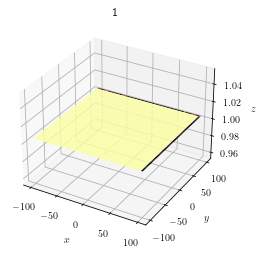

In [2]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

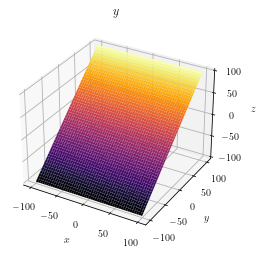

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

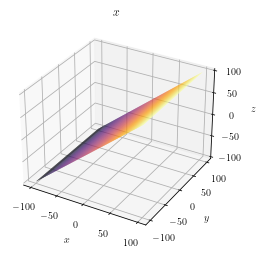

In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

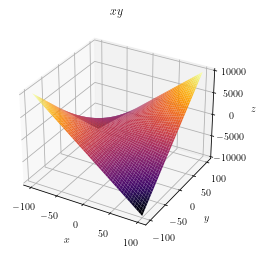

In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

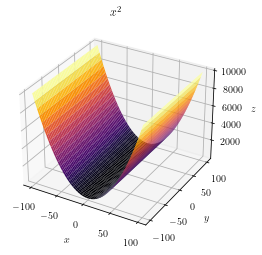

In [6]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

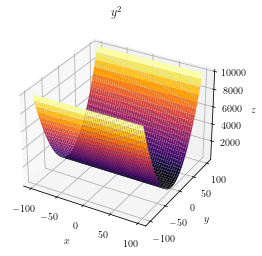

In [7]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Testing with moving circles (max_abs_motion=1)

In [8]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 1).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/001.png (64, 64, 3) uint8 684 


255 0 int16


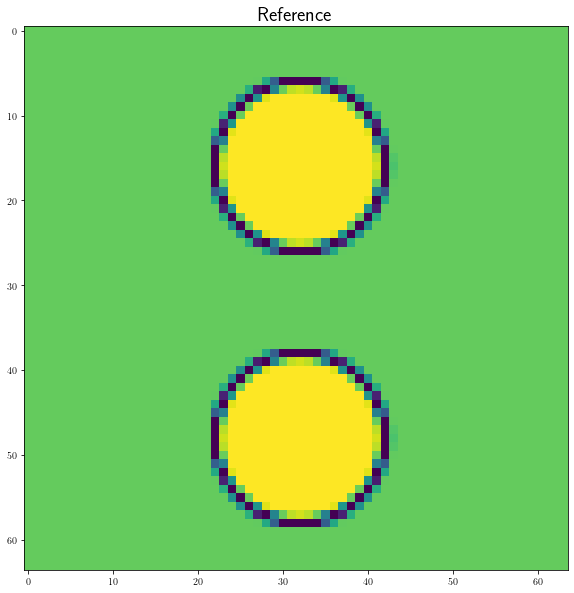

In [9]:
image_1.show(R, "Reference")

255 0 int16


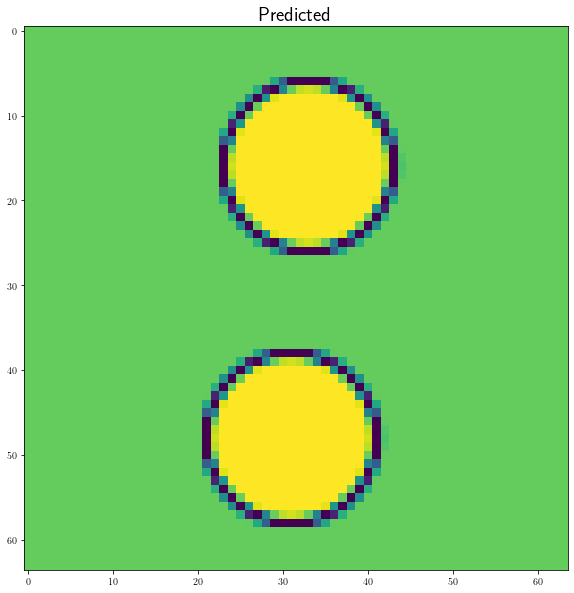

In [10]:
image_1.show(P, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [11]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs)

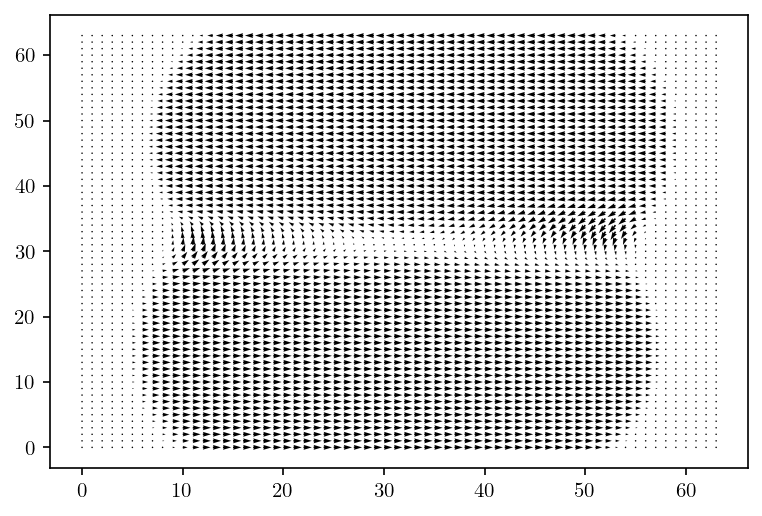

In [12]:
motion.show_vectors(MVs[::1, ::1])

In [13]:
hat_P = motion.make_prediction(reference=R, MVs=MVs)

255 0 int16
255 0 int16
134 124 uint8


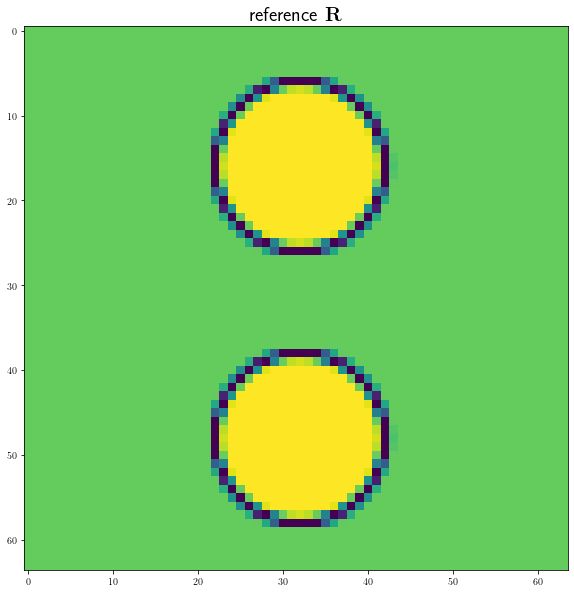

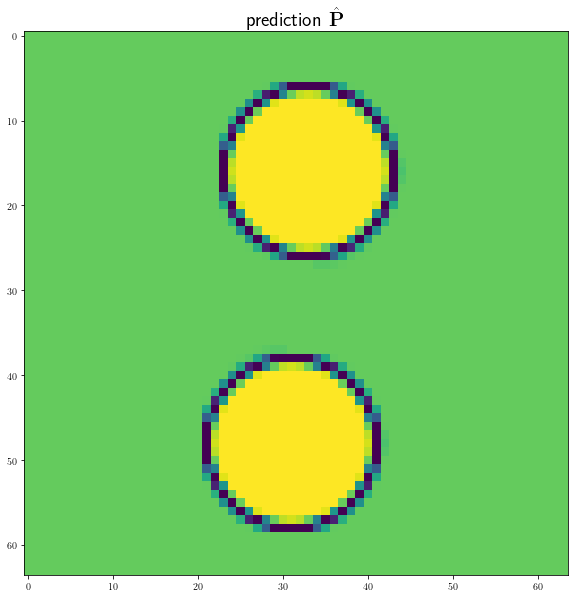

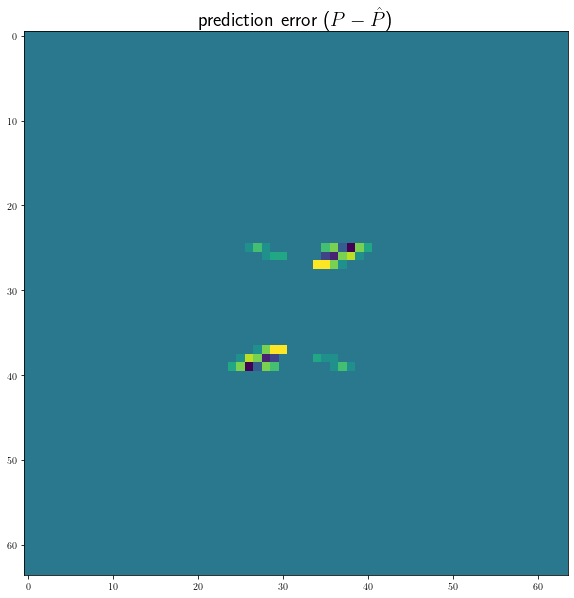

In [14]:
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(hat_P, "prediction $\hat{\mathbf P}$")
image_1.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [15]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 2).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/002.png (64, 64, 3) uint8 684 


255 0 int16
255 0 int16


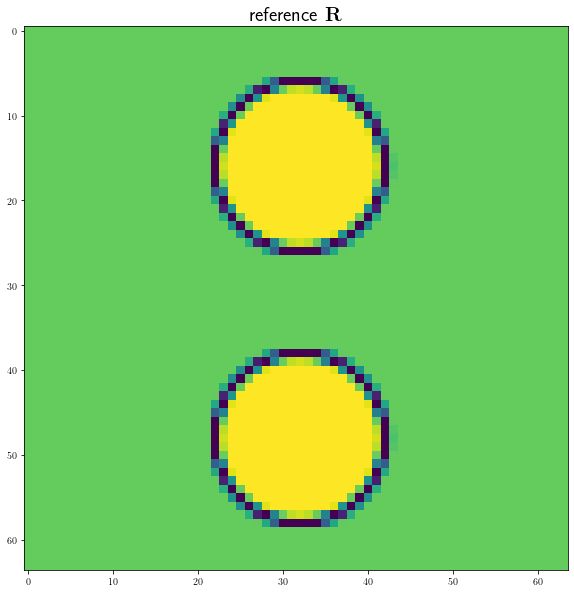

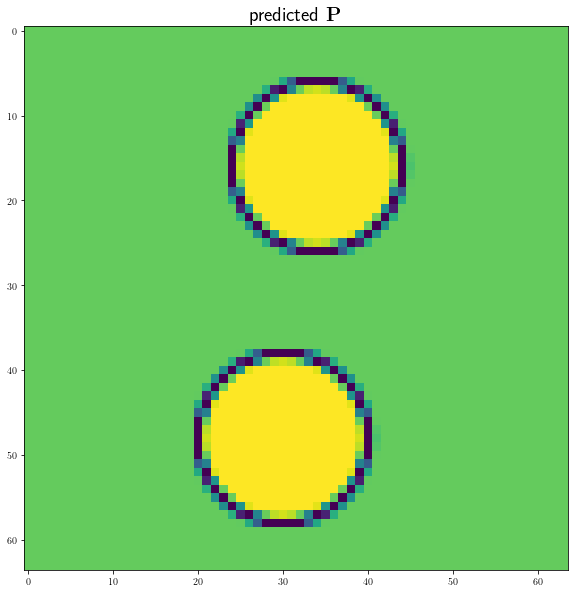

In [16]:
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(P, "predicted ${\mathbf P}$")

In [17]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs)

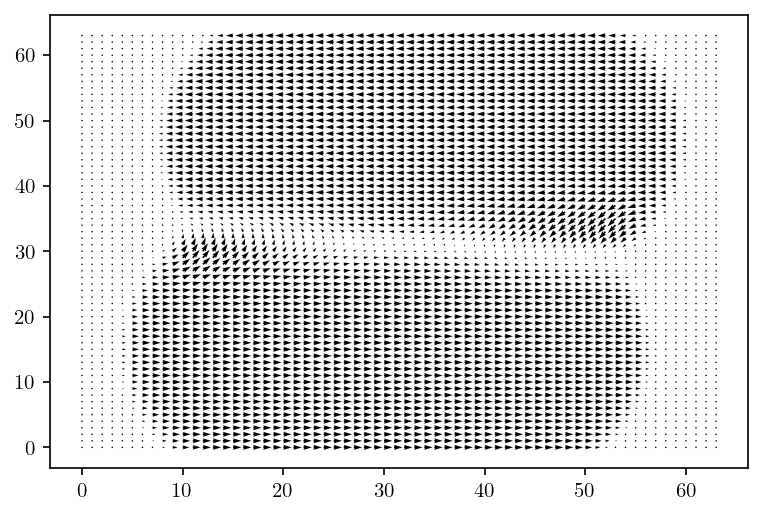

In [18]:
motion.show_vectors(MVs[::1, ::1])

255 0 int16
140 117 uint8


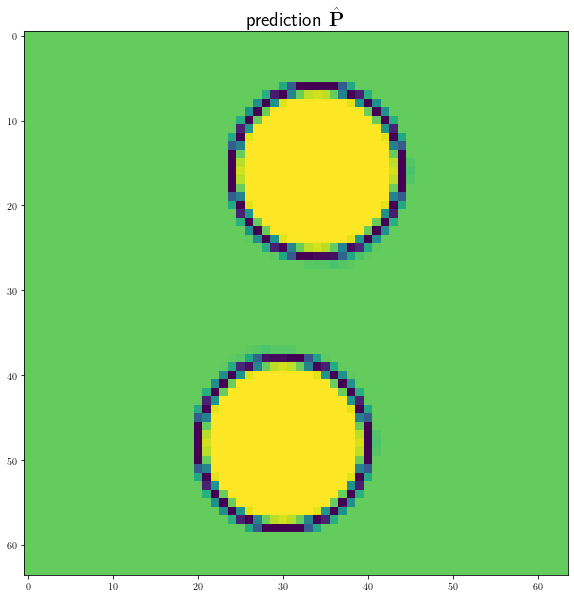

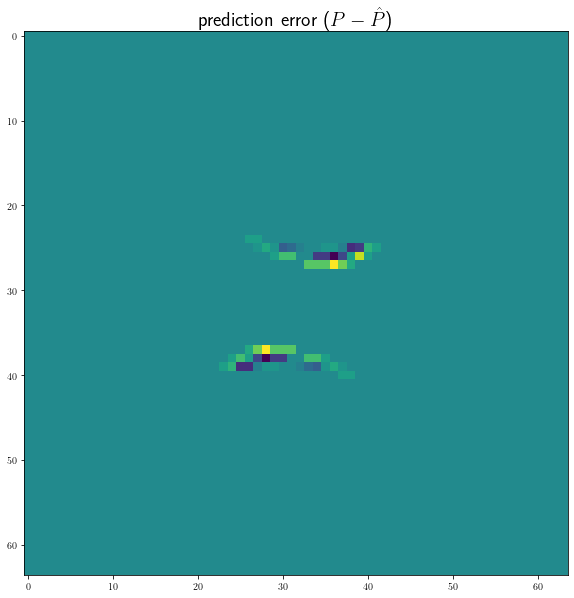

In [19]:
hat_P = motion.make_prediction(R, MVs)
image_1.show(hat_P, "prediction $\hat{\mathbf P}$")
image_1.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [20]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 4).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/004.png (64, 64, 3) uint8 684 


255 0 int16
255 0 int16


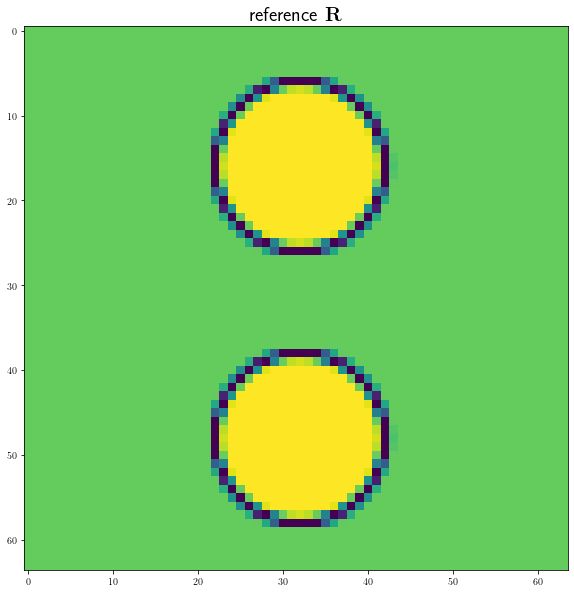

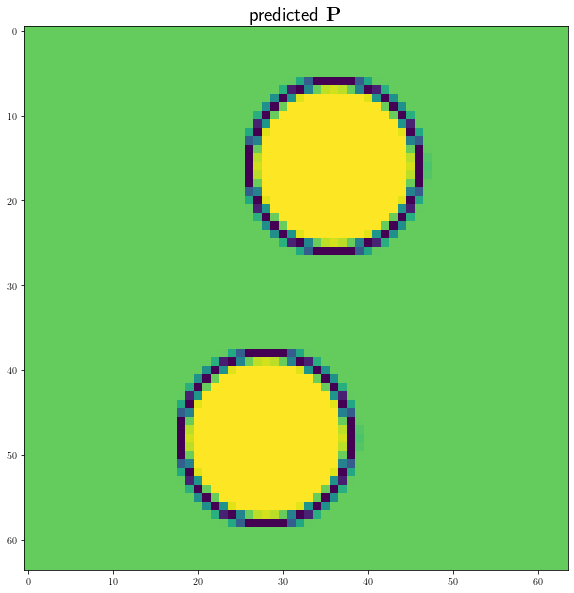

In [21]:
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(P, "predicted ${\mathbf P}$")

In [22]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs)

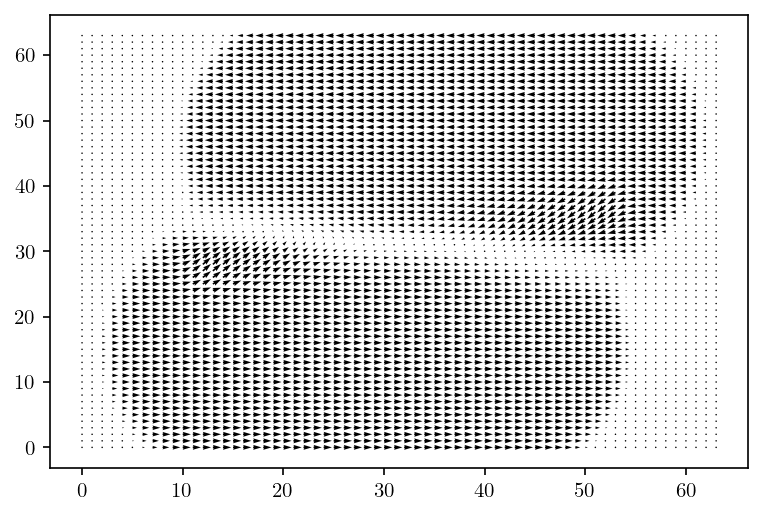

In [23]:
motion.show_vectors(MVs[::1, ::1])

255 0 int16
146 109 uint8


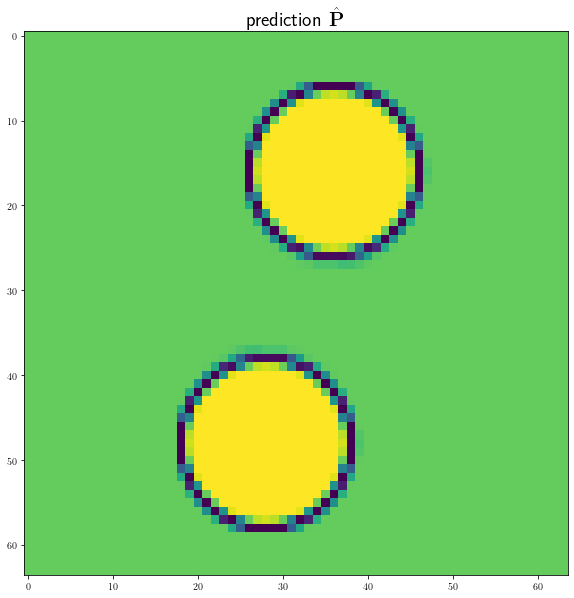

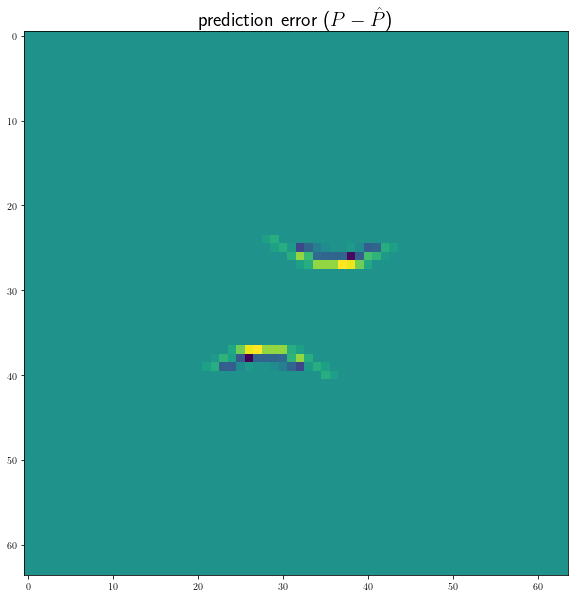

In [24]:
hat_P = motion.make_prediction(R, MVs)
image_1.show(hat_P, "prediction $\hat{\mathbf P}$")
image_1.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

### Conclusion
Farnebäck's ME does not always minimizes the L$_2$ distance.

## Tile of Stockholm

image_3.read: /home/vruiz/MRVC/sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
image_3.read: /home/vruiz/MRVC/sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 
component=0 max=255 min=0 dtype=uint8
component=1 max=251 min=0 dtype=uint8
component=2 max=246 min=0 dtype=uint8
component=0 max=255 min=0 dtype=uint8
component=1 max=251 min=0 dtype=uint8
component=2 max=242 min=0 dtype=uint8


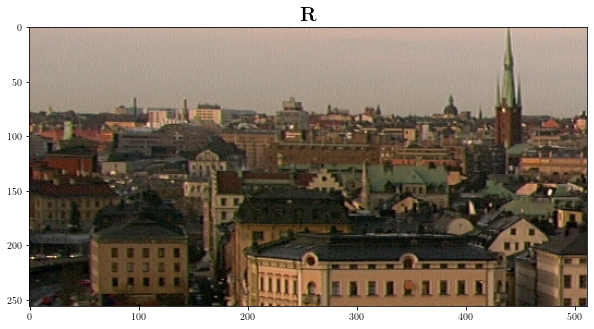

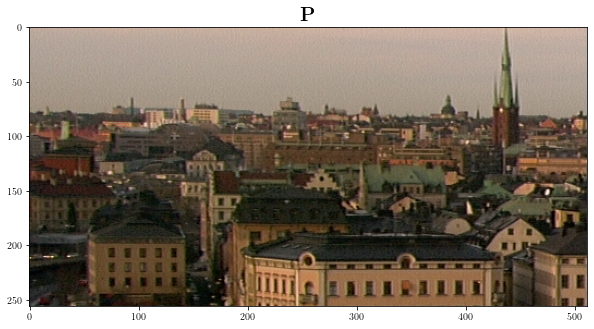

In [25]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = image_3.read(prefix, 0)[slice_Y, slice_X]
P = image_3.read(prefix, 1)[slice_Y, slice_X]
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]
image_3.show(R, "${\mathbf R}$")
image_3.show(P, "${\mathbf P}$")

In [26]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [27]:
MVs.dtype

dtype('float32')

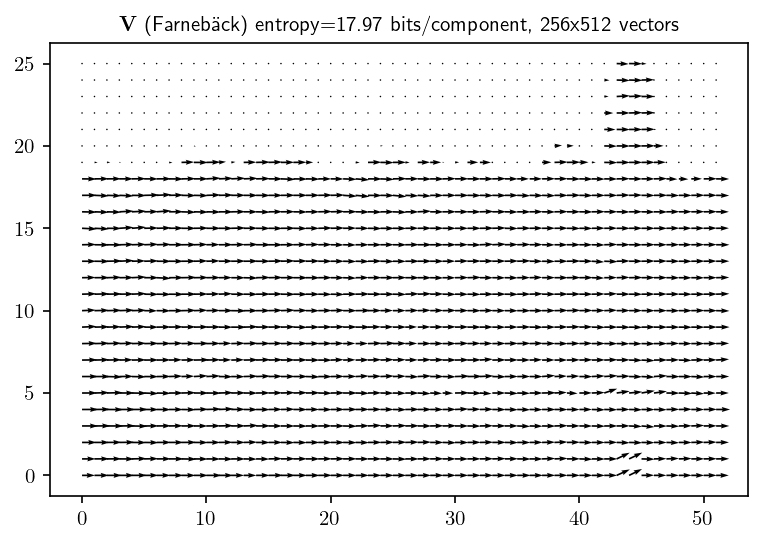

In [28]:
entropy = information.entropy(MVs.flatten())
motion.show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

component=0 max=255 min=0 dtype=uint8
component=1 max=247 min=0 dtype=uint8
component=2 max=230 min=0 dtype=uint8
component=0 max=213 min=74 dtype=uint8
component=1 max=201 min=72 dtype=uint8
component=2 max=199 min=79 dtype=uint8


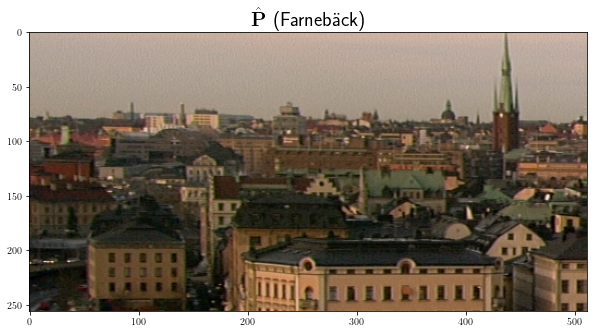

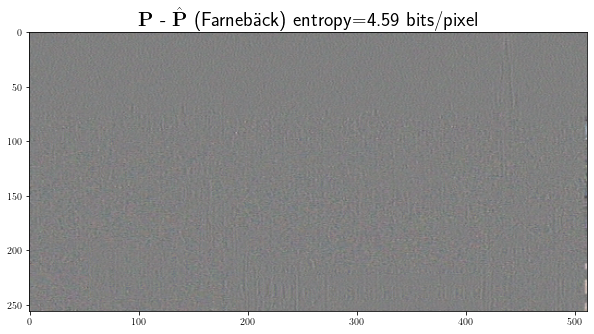

In [29]:
hat_P = motion.make_prediction(R, MVs)
image_3.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
image_3.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.